In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from tqdm import tqdm
init_notebook_mode(connected=True)

pd.options.display.max_columns = 500
#import pandas_profiling

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

var_list = [f for f in train_df.columns if 'var' in f]


In [4]:



train_len = train_df.shape[0]
merged_df = pd.concat([train_df, test_df],sort=False)



In [24]:

for var in tqdm(var_list):
    
    merged_df['random_{}'.format(var)] = np.random.normal(merged_df[var].mean(), merged_df[var].std(), 400000).round(4)
    merged_df['frequency_{}'.format(var)] = merged_df[var].map(merged_df[var].value_counts())
    merged_df['true_frequency_{}'.format(var)] = merged_df[var].map(merged_df['random_{}'.format(var)].value_counts())
    merged_df['true_frequency_{}'.format(var)].fillna(0,inplace=True)
    merged_df['freq_diff_{}'.format(var)] = abs(merged_df['frequency_{}'.format(var)] - merged_df['true_frequency_{}'.format(var)]) 
    
    
    
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.24it/s]


In [ ]:

for var in tqdm(var_list):
    
    merged_df['random_{}'.format(var)] = np.random.normal(merged_df[var].mean(), merged_df[var].std(), 400000).round(4)
    merged_df['frequency_{}'.format(var)] = merged_df[var].map(merged_df[var].value_counts())
    merged_df['true_frequency_{}'.format(var)] = merged_df[var].map(merged_df['random_{}'.format(var)].value_counts())
    merged_df['true_frequency_{}'.format(var)].fillna(0,inplace=True)
    merged_df['freq_diff_{}'.format(var)] = abs(merged_df['frequency_{}'.format(var)] - merged_df['true_frequency_{}'.format(var)]) 
    
    
    
    

In [26]:
merged_df.isna().sum().sum()

200000

In [27]:

train_df = merged_df.iloc[:train_len]
test_df = merged_df.iloc[train_len:]

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

n_folds = 5
random_seed = 26
model = 'frequency_diff_to_random'


model_name = "{0}_{1}_folds".format(model, n_folds)
print("Model: {}".format(model_name))

Model: frequency_diff_to_random_5_folds


In [29]:
test_df.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'true_frequency_var_197', 'freq_diff_var_197', 'random_var_198',
       'frequency_var_198', 'true_frequency_var_198', 'freq_diff_var_198',
       'random_var_199', 'frequency_var_199', 'true_frequency_var_199',
       'freq_diff_var_199'],
      dtype='object', length=1002)

In [30]:

exclusion = ['ID_code', 'target'] 

for var in tqdm(var_list):
    exclusion.append('frequency_{}'.format(var))
    exclusion.append('random_{}'.format(var))
    
feats = [c for c in train_df.columns if c not in exclusion]



100%|████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<?, ?it/s]


In [31]:
feats
    

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

Current Fold: 1
Training until validation scores don't improve for 50 rounds.
[500]	training's auc: 0.893586	valid_1's auc: 0.870723
[1000]	training's auc: 0.914801	valid_1's auc: 0.888361
[1500]	training's auc: 0.924802	valid_1's auc: 0.895576
[2000]	training's auc: 0.93229	valid_1's auc: 0.898287
Early stopping, best iteration is:
[2212]	training's auc: 0.935509	valid_1's auc: 0.899141
AUC = 0.8991406810753215
Current Fold: 2
Training until validation scores don't improve for 50 rounds.
[500]	training's auc: 0.893592	valid_1's auc: 0.872455
[1000]	training's auc: 0.914826	valid_1's auc: 0.889304
[1500]	training's auc: 0.925001	valid_1's auc: 0.895495
[2000]	training's auc: 0.932554	valid_1's auc: 0.898117
Early stopping, best iteration is:
[2040]	training's auc: 0.933149	valid_1's auc: 0.898258
AUC = 0.8982578906694951
Current Fold: 3
Training until validation scores don't improve for 50 rounds.
[500]	training's auc: 0.89355	valid_1's auc: 0.87846
[1000]	training's auc: 0.914405	vali

C:\Users\TanQ\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



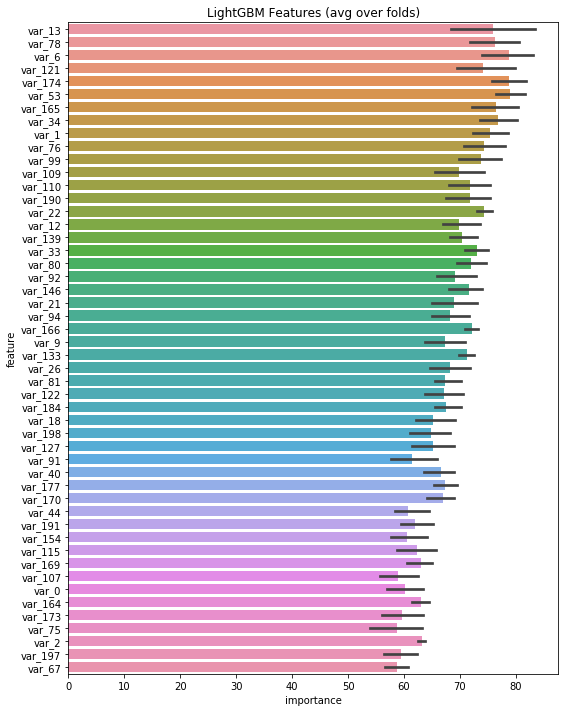

In [32]:
clfs = []
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))


X = train_df[feats]
y = train_df['target']
X_test = test_df[feats]
test_ids = test_df.ID_code.values


parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 5, #31
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'learning_rate': 0.05, #0.05
    'verbose': 30
    #'min_data_in_leaf': 200
}

feature_importance_df = pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))
    trn_x, trn_y = X.iloc[trn_, :], y[trn_]
    val_x, val_y = X.iloc[val_, :], y[val_]
    
    
#     for col_index, new_col_name in enumerate(tqdm(new_cols)):
#         trn_x[new_col_name] = trn_x.iloc[:,[col_index]].apply(lambda x: x.map(trn_x.iloc[:,col_index].value_counts()))
#         X_test[new_col_name] = X_test.iloc[:,[col_index]].apply(lambda x: x.map(trn_x.iloc[:,col_index].value_counts()))
#         val_x[new_col_name] = val_x.iloc[:,[col_index]].apply(lambda x: x.map(trn_x.iloc[:,col_index].value_counts()))
        
    trn_lgb = lgb.Dataset(trn_x, trn_y)
    val_lgb = lgb.Dataset(val_x, val_y)
    clf = lgb.train(parameters,
                     train_set=trn_lgb,
                     #valid_sets=[valid_data_lgb,holdout_data_lgb],
                     valid_sets=[trn_lgb, val_lgb],
                     num_boost_round=30000,
                     early_stopping_rounds=50,
                     verbose_eval=500)
    


    val_pred = clf.predict(val_x)
    test_fold_pred = clf.predict(X_test)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
   # print('getting feature importance')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
test_preds /= n_folds
roc_score = roc_auc_score(y, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))


print("Saving submission file")
sample = pd.read_csv('../data/sample_submission.csv')
sample.target = test_preds.astype(float)
sample.ID_code = test_ids
sample.to_csv('../submissions/{}_{}.csv'.format(model_name,str(roc_score)), index=False)

display_importances(feature_importance_df)
